<a href="https://colab.research.google.com/github/NoobCoder-dweeb/AI-HandsOn-Journey/blob/main/notes/DQN_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test RL from OpenAI Gym

In [ ]:
import gym
import numpy as np
import warnings

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the environment with render mode specified
env = gym.make('CartPole-v1', render_mode="human")

# Initialize the environment to get the initial state
state = env.reset()

# Print the state space and action space
print("State space:", env.observation_space)
print("Action space:", env.action_space)

# Run a few steps in the environment with random actions
for _ in range(10):
    env.render()  # Render the environment for visualization
    action = env.action_space.sample()  # Take a random action

    # Take a step in the environment
    step_result = env.step(action)

    # Check the number of values returned and unpack accordingly
    if len(step_result) == 4:
        next_state, reward, done, info = step_result
        terminated = False
    else:
        next_state, reward, done, truncated, info = step_result
        terminated = done or truncated

    print(f"Action: {action}, Reward: {reward}, Next State: {next_state}, Done: {done}, Info: {info}")

    if terminated:
        state = env.reset()  # Reset the environment if the episode is finished

env.close()  # Close the environment when done


State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Action: 1, Reward: 1.0, Next State: [ 0.01766587  0.22777702 -0.03938409 -0.3544966 ], Done: False, Info: {}
Action: 1, Reward: 1.0, Next State: [ 0.02222141  0.4234362  -0.04647402 -0.6593337 ], Done: False, Info: {}
Action: 1, Reward: 1.0, Next State: [ 0.03069013  0.61917305 -0.0596607  -0.96628046], Done: False, Info: {}
Action: 0, Reward: 1.0, Next State: [ 0.04307359  0.42490095 -0.0789863  -0.69292057], Done: False, Info: {}
Action: 1, Reward: 1.0, Next State: [ 0.05157161  0.62102467 -0.09284472 -1.0093868 ], Done: False, Info: {}
Action: 0, Reward: 1.0, Next State: [ 0.06399211  0.42725632 -0.11303245 -0.7472432 ], Done: False, Info: {}
Action: 0, Reward: 1.0, Next State: [ 0.07253723  0.23386022 -0.12797731 -0.49216112], Done: False, Info: {}
Action: 0, Reward: 1.0, Next State: [ 0.07721443  0.04075

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim # Adam
import torch.nn.functional as F # relu
import numpy as np


class DeepQNetwork(nn.Module):
  def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
    super(DeepQNetwork, self).__init__()
    self.input_dims = input_dims
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    actions = self.fc3(x) # get agent raw estimate. can be negative value

    return actions

class Agent():
  def __init__(self, gamma, epsilon, lr, input_dims,
               batch_size, n_actions, max_mem_size=100000,
               eps_end=0.01, eps_dec=1e-3):
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_end
    self.eps_dec = eps_dec
    self.lr = lr
    self.action_space = [i for i  in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr = 0

    self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
    self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = done

    self.mem_cntr += 1

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      # take best knwon answer
      if len(observation) < self.Q_eval.input_dims[0]:
        observation = np.array([observation[0]])

      state = torch.tensor([observation]).to(self.Q_eval.device)
      actions = self.Q_eval.forward(state)
      action = torch.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)

    return action

  def learn(self):
    if self.mem_cntr < self.batch_size:
      return

    self.Q_eval.optimizer.zero_grad()

    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, self.batch_size, replace=False)
    # for index slicing
    batch_index = np.arange(self.batch_size, dtype=np.int32)

    state_batch = torch.tensor(self.state_memory[batch]).to(self.Q_eval.device)
    new_state_batch = torch.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = torch.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch = torch.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch]

    q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
    q_next = self.Q_eval.forward(new_state_batch)
    q_next[terminal_batch] = 0.0

    q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    # self.epsilon = self.epsilon - (self.eps_dec if self.epsilon > self.eps_min else self.eps_min)
    self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)


def plot_learning_curve(x, scores, epsilons, filename, lines=None):
  import matplotlib.pyplot as plt
  fig = plt.figure()
  ax = fig.add_subplot(111, label='1')
  ax2 = fig.add_subplot(111, label='2', frame_on=False)
  ax.plot(x, epsilons, color='C0')
  ax.set_xlabel("Training Steps", color="C0")
  ax.set_ylabel("Epsilon", color="C0")
  ax.tick_params(axis='x', colors="C0")
  ax.tick_params(axis='y', colors="C0")

  N = len(scores)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

  ax2.scatter(x, scores, color='C1')
  ax2.plot(x, running_avg, 'C1-')
  ax2.axes.get_xaxis().set_visible(False)
  ax2.yaxis.tick_right()
  ax2.set_ylabel('Score', color='C1')
  ax2.yaxis.set_label_position('right')
  ax2.tick_params(axis='y', colors='C1')

  if lines is not None:
    for line in lines:
      plt.axvline(x=line)

  plt.savefig(filename)

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]
# !pip install --upgrade -q sympy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


episode 0, score -92.38,           average score -92.38, epsilon 0.97


<ipython-input-4-846edbad67c5>:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([observation]).to(self.Q_eval.device)


episode 1, score -89.91,           average score -91.15, epsilon 0.90
episode 2, score -108.85,           average score -97.05, epsilon 0.84
episode 3, score -113.98,           average score -101.28, epsilon 0.69
episode 4, score -563.69,           average score -193.76, epsilon 0.54
episode 5, score -397.49,           average score -227.72, epsilon 0.45
episode 6, score -499.15,           average score -266.49, epsilon 0.35
episode 7, score -608.51,           average score -309.25, epsilon 0.23
episode 8, score -816.28,           average score -365.58, epsilon 0.11
episode 9, score -520.69,           average score -381.09, epsilon 0.03
episode 10, score -914.49,           average score -429.58, epsilon 0.01
episode 11, score -604.40,           average score -444.15, epsilon 0.01
episode 12, score -724.46,           average score -465.71, epsilon 0.01
episode 13, score -329.22,           average score -455.96, epsilon 0.01
episode 14, score -639.77,           average score -468.22, eps

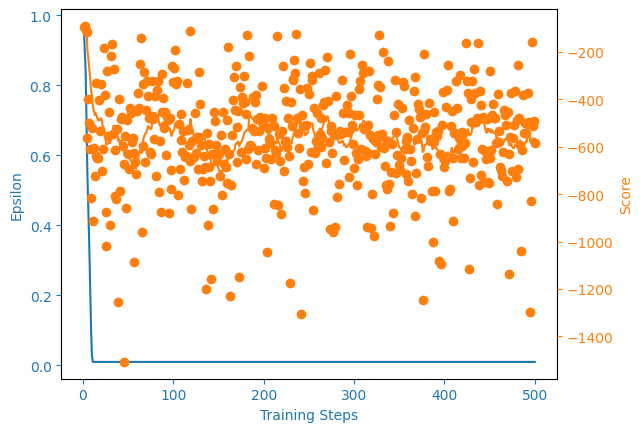

In [ ]:
import gymnasium as gym

env = gym.make('LunarLander-v3')
# epsilon => 1.0==fully random, 0.0==precedented
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01, input_dims=[8], lr=0.003)

scores, eps_history = [], []
n_games = 500

for i in range(n_games):
  score = 0
  done = False
  observation = env.reset()
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, terminated, truncated, info = env.step(action)
    done = terminated
    score += reward
    # print(observation, observation_)
    agent.store_transition(observation[0], action, reward, observation_, done)
    agent.learn()
    observation = observation_
  scores.append(score)
  eps_history.append(agent.epsilon)
  avg_score = np.mean(scores[-100:])
  print(f"episode {i}, score {score:.2f}, \
          average score {avg_score:.2f}, epsilon {agent.epsilon:.2f}")

x = [i+1 for i in range(n_games)]
filename = 'lunarlander.png'
plot_learning_curve(x, scores, eps_history, filename)

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Complete


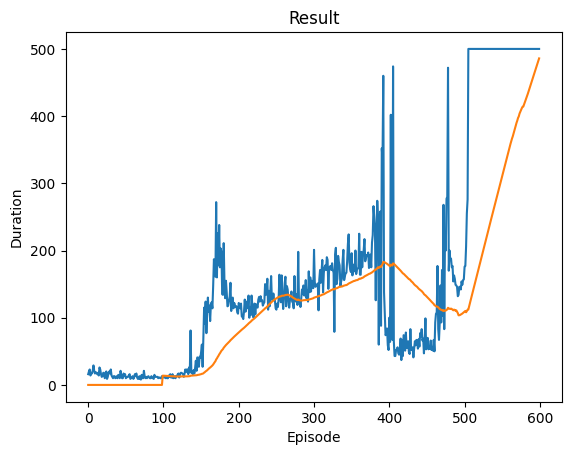

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()